In [46]:
import torch.nn as nn
import torch
import torch.nn.functional as F
import os
import requests


In [47]:
if not os.path.exists("sales_textbook.txt"):
    url = 'https://huggingface.co/datasets/goendalf666/sales-textbook_for_convincing_and_selling/raw/main/sales_textbook.txt'
    with open('sales_textbook.txt', 'w') as f:
        f.write(requests.get(url).text)

with open('sales_textbook.txt') as f:
    text = f.read()

print(text)

Chapter 1: Building Rapport and Capturing Attention
Subpoint: Understanding the Importance of Building Rapport
Building rapport is a fundamental skill in sales that cannot be underestimated. It lays the foundation for establishing a connection with your potential customers, gaining their trust, and ultimately convincing them to make a purchase. Rapport can be defined as a harmonious relationship based on mutual understanding and empathy. When you build rapport with someone, you create a sense of familiarity, comfort, and shared interests, making it easier to communicate and influence their decision-making process.
One of the main reasons why building rapport is crucial in sales is that people are more likely to buy from someone they like and trust. By establishing a positive and genuine connection with your customers, you increase their confidence in you and your product or service. People want to do business with individuals they feel comfortable with, those who understand their needs

In [48]:
#hyparameters
batch_size = 4
context_size = 16
d_model = 64
num_heads = 4
num_layers = 6
dropout = 0.1

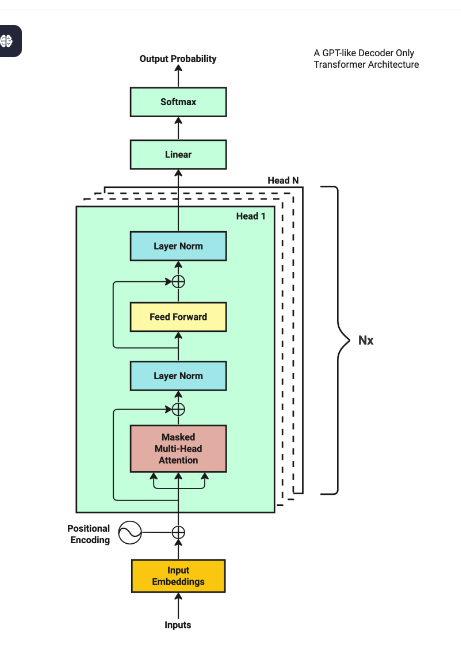  
**Step 1: Tokenization**  
<big>Translates an input sentence into a format of number representations.<big>

In [49]:
#use tiktoken lib as Tokenization
import tiktoken
encoding = tiktoken.get_encoding('cl100k_base')
tokenized_text = encoding.encode(text=text)
tokenized_text = torch.tensor(tokenized_text)
#spilt trian and validiton
train_index = int(len(tokenized_text)*0.9)
train_data = tokenized_text[:train_index]
val_data = tokenized_text[train_index:]
print(len(train_data))
print(len(val_data))
print(len(tokenized_text))

70127
7792
77919


In [50]:
data = train_data
idxs = torch.randint(0, len(data)-context_size, (batch_size,))
x_batch = torch.stack([data[i:i+context_size] for i in idxs])
y_batch = torch.stack([data[i+1:i+context_size+1] for i in idxs])
print(x_batch.shape)

torch.Size([4, 16])


In [51]:
import pandas as pd
pd.DataFrame(x_batch.numpy())
encoding.decode(x_batch[0].numpy())

' a sense of scarcity\nIn this chapter, we will delve into the art of'

**Step2 Word Embedding**  

In [52]:
max_token_value = max(tokenized_text).item()
token_embedding_lookup_table = nn.Embedding(max_token_value + 1, d_model)
x_embedding = token_embedding_lookup_table(x_batch)
y_embedding = token_embedding_lookup_table(y_batch)
print(token_embedding_lookup_table)

Embedding(100070, 64)


**Step3 Positional Embedding**  
两个维度的含义
pos（位置索引） → 决定了这是句子里第几个 token，例如第 0 个词、第 1 个词……

i（维度索引） → 决定了这个位置编码向量里的第几个分量，例如维度 0、维度 1、维度 2……

位置编码矩阵的形状是：
(context_size, d_model)
比如 context_size=4, d_model=8，形状就是 (4, 8)：

行 → 不同的 pos（0,1,2,3）

列 → 不同的 embedding 维度（0 到 7）

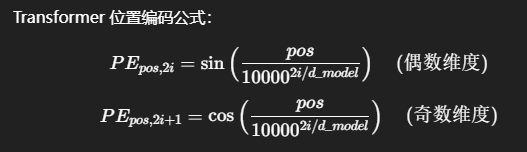

In [53]:
position_encoding_lookup_table = torch.zeros(context_size, d_model)
#偶数维度用sin 奇数维度用cos
'''
unsqueeze(1): (context_size,) -> (context_size, 1)
这样再跟 (d_model/2,) 运算时，PyTorch 会按广播规则扩展成：
pos: (context_size, 1) → 扩展成 (context_size, d_model/2)
i: (d_model/2,) → 扩展成 (context_size, d_model/2)
得到一个二维矩阵，每一行是同一个位置 pos 对应的所有频率计算结果。
'''
position_encoding_lookup_table[:, 0::2] = torch.sin(torch.arange(0, context_size, dtype=torch.float32).unsqueeze(1) / (10000 ** (torch.arange(0, d_model, 2).float() / d_model)))
position_encoding_lookup_table[:, 1::2] = torch.cos(torch.arange(0, context_size, dtype=torch.float32).unsqueeze(1) / (10000 ** (torch.arange(0, d_model, 2).float() / d_model)))
print(position_encoding_lookup_table.size())
x = x_embedding + position_encoding_lookup_table
y = y_embedding + position_encoding_lookup_table
print(x.shape,y.shape)

torch.Size([16, 64])
torch.Size([4, 16, 64]) torch.Size([4, 16, 64])


**Step4 Transformer BLock**  
> .masked_fill(mask, value) 会用指定的值 value 替换掉张量中 mask 为 True 的位置.    
> - mask 必须是 布尔型张量（True/False），或者老版本 PyTorch 也支持 byte 类型  
> - value 是要填充的值，可以是数字（比如 -inf、0、-1e9）或和张量同形状的张量  
> - mask 的形状可以和目标张量相同，也可以通过广播匹配目标张量的形状。  

> torch.triu(torch.ones(attention_scores.shape[-2:]), diagonal=1).bool()  
> - 效果：  
tensor([[False,  True,  True,  True],  
         [False, False,  True,  True],  
         [False, False, False,  True],  
         [False, False, False, False]])  

**Step4.1 Transformer BLock - attention_score(Q K V)**  

In [54]:
q,k,v = x, x, x #[batch_size, context_size, d_model]
Wq = nn.Linear(d_model, d_model)
Wk = nn.Linear(d_model, d_model)
Wv = nn.Linear(d_model, d_model)

Q = Wq(q)
K = Wk(k)
V = Wv(v)   
Q = Q.view(batch_size, context_size, num_heads, d_model // num_heads).transpose(1, 2)  
# ->[batch_size, num_heads, context_size, d_model // num_heads] ->[4,4,16,64/4]
K = K.view(batch_size, context_size, num_heads, d_model // num_heads).transpose(1, 2)
V = V.view(batch_size, context_size, num_heads, d_model // num_heads).transpose(1, 2)

attention_scores = torch.matmul(Q, K.transpose(-2, -1)) / (d_model ** 0.5)
#torch.triu(input, diagonal=0)：返回输入张量的上三角部分（lower part 被置为 0）
attention_scores = attention_scores.masked_fill(torch.triu(torch.ones(attention_scores.shape[-2:]), diagonal=1).bool(), float('-inf'))
print(torch.triu(torch.ones(attention_scores.shape[-2:]), diagonal=1).bool())
pd.DataFrame(attention_scores[0][0].detach().cpu().numpy())

tensor([[False,  True,  True,  True,  True,  True,  True,  True,  True,  True,
          True,  True,  True,  True,  True,  True],
        [False, False,  True,  True,  True,  True,  True,  True,  True,  True,
          True,  True,  True,  True,  True,  True],
        [False, False, False,  True,  True,  True,  True,  True,  True,  True,
          True,  True,  True,  True,  True,  True],
        [False, False, False, False,  True,  True,  True,  True,  True,  True,
          True,  True,  True,  True,  True,  True],
        [False, False, False, False, False,  True,  True,  True,  True,  True,
          True,  True,  True,  True,  True,  True],
        [False, False, False, False, False, False,  True,  True,  True,  True,
          True,  True,  True,  True,  True,  True],
        [False, False, False, False, False, False, False,  True,  True,  True,
          True,  True,  True,  True,  True,  True],
        [False, False, False, False, False, False, False, False,  True,  True,
    

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
0,0.032315,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf
1,-0.196740,0.039771,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf
2,-0.445998,0.030143,0.002119,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf
3,-0.177509,-0.000885,-0.066241,0.077782,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf
4,-0.051518,-0.052636,0.222376,0.215408,0.178894,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf
5,-0.195255,0.116327,0.286971,-0.025718,0.002253,-0.041484,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf
6,-0.343410,0.132766,0.170533,0.258448,0.168663,-0.229527,0.039075,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf
7,0.095815,0.227371,0.402108,0.094301,0.032630,-0.012072,-0.252136,0.111457,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf
8,-0.255007,0.235885,-0.383378,-0.229002,0.233062,0.219738,-0.317795,0.266973,-0.489874,-inf,-inf,-inf,-inf,-inf,-inf,-inf
9,-0.096440,-0.172210,-0.206677,-0.072469,0.102632,0.322928,-0.096467,-0.068111,-0.333872,0.041709,-inf,-inf,-inf,-inf,-inf,-inf


**Step4.2 Transformer BLock - softmax**  

In [55]:
attention_scores = torch.softmax(attention_scores, dim=-1)
pd.DataFrame(attention_scores[0][0].detach().cpu().numpy())

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
0,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,0.441146,0.558854,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,0.239509,0.385573,0.374918,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,0.217310,0.259291,0.242887,0.280512,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,0.170096,0.169906,0.223689,0.222136,0.214172,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
5,0.132370,0.180762,0.214396,0.156826,0.161274,0.154373,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
6,0.096501,0.155358,0.161337,0.176163,0.161036,0.108141,0.141463,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
7,0.124133,0.141586,0.168620,0.123945,0.116532,0.111438,0.087655,0.126090,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
8,0.089353,0.145982,0.078588,0.091707,0.145571,0.143644,0.083915,0.150592,0.070649,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
9,0.094754,0.087839,0.084863,0.097052,0.115625,0.144120,0.094751,0.097476,0.074728,0.108791,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [56]:
A = torch.matmul(attention_scores, V)  # [batch_size, num_heads, context_size, d_model // num_heads]
A = A.transpose(1,2)
A = A.reshape(batch_size, context_size, -1)
print(A.shape)

Wo = nn.Linear(d_model, d_model)
output = Wo(A)  # [batch_size, context_size, d_model]
print(output.shape)

torch.Size([4, 16, 64])
torch.Size([4, 16, 64])


**Step 5: Residual Connection and Layer Normalization**

In [57]:
output = output + x  # 残差连接
layer_norm = nn.LayerNorm(d_model)
layer_norm_output = layer_norm(output)

**Step 6: Feed Forward Network**

In [58]:
ffn = nn.Sequential(
    nn.Linear(d_model, d_model*4),
    nn.ReLU(),
    nn.Linear(d_model*4, d_model),
    nn.Dropout(p=0.1)  # Assuming training mode, set to False during inference
)
output = ffn(layer_norm_output)  # [batch_size, context_size, d_model]
output = output + layer_norm_output  # 残差连接

print(output.shape)

torch.Size([4, 16, 64])


**Step 7: Repeat 4-6**

**Step 8: Final Layer**

In [77]:
final_linear = nn.Linear(d_model, max_token_value + 1)
logits = final_linear(output)  # [batch_size, context_size, max_token_value + 1]
probability = torch.softmax(logits, dim=-1)  # Apply softmax to get probabilities
print(probability.shape)
pd.DataFrame(probability[0].detach().cpu().numpy()) 
print(torch.argmax(probability[0], dim=-1).numpy())
print(encoding.decode(torch.argmax(probability[0], dim=-1).numpy()))

torch.Size([4, 16, 100070])
[  790 95338 51665 57804 70191 57186 67059 79691  4768 40584 96417 75890
 12083  7109 54834 26469]
ST$clientScient doGetmenoции Umbüzague                                                                               _MSK-resource_MIN.httpKill-ser
